# Finite Element Analysis - Plate with Circular Hole under Tension

This notebook uses the finite element method to analyze stress distribution in a plate with a circular hole under tensile loading, and studies convergence through mesh refinement.

## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

## 2. Physical and Material Parameters

Set elastic modulus, Poisson's ratio, geometric parameters, and construct the stiffness matrix for plane strain problem.

In [2]:
# Physical and material parameters
E   = 1.0e3       # Elastic modulus
nu  = 0.30        # Poisson's ratio
Tx  = 1.0         # Tensile load
R   = 1.0         # Hole radius
L   = 5.0         # Plate boundary size
ndof = 2          # Degrees of freedom per node
ncoord = 2        # Coordinates per node
eleType = 4       # Element type (quadrilateral)
nelem_1D = 20     # Number of elements in one direction

# Material properties for plane strain problem
materialprops = [0.5*E/(1.0+nu), nu, 1]
mu = materialprops[0]
lambda_ = 2.0*mu*nu/(1.0-2.0*nu)

# Stiffness matrix D for plane strain problem
D = np.array([
    [lambda_ + 2*mu, lambda_,        0.0],
    [lambda_,        lambda_ + 2*mu, 0.0],
    [0.0,            0.0,            mu]
])

print("Material stiffness matrix D:")
print(D)

Material stiffness matrix D:
[[1346.15384615  576.92307692    0.        ]
 [ 576.92307692 1346.15384615    0.        ]
 [   0.            0.          384.61538462]]


## 3. Analytical Stress Functions

Define the analytical solution for the plate with hole problem (stress components in polar coordinates).

In [3]:
def f_srr(rr, th):
    """Radial stress analytical solution"""
    return 0.5*Tx*(1.0-rr**2.0) + 0.5*Tx*(1.0-4.0*rr**2.0+3.0*rr**4.0)*np.cos(2.0*th)

def f_stt(rr, th):
    """Circumferential stress analytical solution"""
    return 0.5*Tx*(1.0+rr**2.0) - 0.5*Tx*(1.0+3.0*rr**4.0)*np.cos(2.0*th)

def f_srt(rr, th):
    """Shear stress analytical solution"""
    return -0.5*Tx*(1.0+2.0*rr**2.0-3.0*rr**4.0)*np.sin(2.0*th)

## 4. Mesh Generation Function

Generate structured mesh for plate with hole, including node coordinates, element connectivity, and boundary conditions.

In [4]:
def mesh_platehole_matlab(nelem_1D):
    
    nnode_1D = nelem_1D + 1  
    
    
    nnode = nnode_1D**2 * 2 - nnode_1D
    nelem = nelem_1D**2 * 2
    
    
    th = np.linspace(0.0, np.pi/4.0, nnode_1D)
    x_1, y_1, x_2, y_2 = [], [], [], []
    
    for irow in range(nnode_1D):
        
        x_row = np.linspace(np.cos(th[irow])*R, L, nnode_1D)
        y_row = np.linspace(np.sin(th[irow])*R, L/nelem_1D*irow, nnode_1D)
        
        x_1.extend(x_row)
        y_1.extend(y_row)
        
        
        if irow != nnode_1D - 1:
            x_2 = list(y_row) + x_2  
            y_2 = list(x_row) + y_2  
    
    
    coords = np.array([x_1 + x_2, y_1 + y_2])
    
    
    nfix = nnode_1D * 2
    fixnodes = np.zeros((3, nfix), dtype=int)
    fixnodes[0, :nnode_1D] = np.arange(nnode_1D)
    fixnodes[0, nnode_1D:] = np.arange(nnode - nnode_1D, nnode)
    fixnodes[1, :nnode_1D] = 1  
    fixnodes[1, nnode_1D:] = 0  
    fixnodes[2, :] = 0  
    
    # Surface force boundary conditions
    ndload = nelem_1D * 2
    dloads = np.zeros((4, ndload))
    dloads[0, :] = np.arange(nelem_1D-1, nelem, nelem_1D)  
    dloads[1, :] = 1  
    
    # Calculate surface traction on boundaries
    for idloads in range(ndload):
        nn1 = nnode_1D * (idloads + 1) - 1     
        nn2 = nnode_1D * (idloads + 2) - 1     
        x = 0.5 * (coords[:, nn1] + coords[:, nn2]) 
        r = np.sqrt(x[0]**2 + x[1]** 2)
        th = np.arctan2(x[1], x[0])
        
        # Surface normal vector
        if idloads < nelem_1D:
            fn = np.array([1, 0])  
        else:
            fn = np.array([0, 1])  
        
        # Calculate stress components
        srr = f_srr(R/r, th)
        stt = f_stt(R/r, th)
        srt = f_srt(R/r, th)
        
        # Rotation matrix
        RM = np.array([[np.cos(th), np.sin(th)], 
                       [-np.sin(th), np.cos(th)]])
        
        # Stress tensor in Cartesian coordinates
        s = RM.T @ np.array([[srr, srt], [srt, stt]]) @ RM
        
        # Traction vector
        t = s @ fn
        dloads[2, idloads] = t[0]
        dloads[3, idloads] = t[1]
    
    
    connect = np.zeros((4, nelem), dtype=int)
    rowcount = 0
    
    for elementcount in range(nelem):
        connect[0, elementcount] = elementcount + rowcount
        connect[1, elementcount] = elementcount + rowcount + 1
        connect[2, elementcount] = elementcount + rowcount + nnode_1D + 1
        connect[3, elementcount] = elementcount + rowcount + nnode_1D
        
        if (elementcount + 1) % nelem_1D == 0:
            rowcount += 1
    
    return coords.T, connect.T, fixnodes, dloads, nnode, nelem

## 5. Shape Functions and Derivatives (Q4 Element)

Four-node quadrilateral element shape functions and their partial derivatives.

In [5]:
def shapefunctions_q4(xi, eta):
    N = np.array([
        0.25 * (1 - xi) * (1 - eta),
        0.25 * (1 + xi) * (1 - eta),
        0.25 * (1 + xi) * (1 + eta),
        0.25 * (1 - xi) * (1 + eta)
    ])
    return N

def shapefunctionderivs_q4(xi, eta):
    dNdxi = 0.25 * np.array([
        -(1 - eta),
        (1 - eta),
        (1 + eta),
        -(1 + eta)
    ])
    dNdeta = 0.25 * np.array([
        -(1 - xi),
        -(1 + xi),
        (1 + xi),
        (1 - xi)
    ])
    return dNdxi, dNdeta

## 6. Element Stiffness Matrix

Calculate element stiffness matrix using Gauss integration.

In [6]:
def elstif(coord, D_mat):
    """Calculate element stiffness matrix"""
    # Gauss integration points and weights
    gauss_pts = [-1/np.sqrt(3), 1/np.sqrt(3)]
    weights = [1.0, 1.0]
    
    ke = np.zeros((8, 8))
    
    for xi in gauss_pts:
        for eta in gauss_pts:
            # Shape function derivatives
            dNdxi, dNdeta = shapefunctionderivs_q4(xi, eta)
            
            # Jacobian matrix
            J = np.array([dNdxi, dNdeta]) @ coord
            detJ = np.linalg.det(J)
            invJ = np.linalg.inv(J)
            
            
            dNdxy = invJ @ np.array([dNdxi, dNdeta])
            
            
            B = np.zeros((3, 8))
            for i in range(4):
                B[0, 2*i] = dNdxy[0, i]
                B[1, 2*i+1] = dNdxy[1, i]
                B[2, 2*i] = dNdxy[1, i]
                B[2, 2*i+1] = dNdxy[0, i]
            
            # Element stiffness matrix contribution
            ke += B.T @ D_mat @ B * detJ * weights[0] * weights[1]
    
    return ke

## 7. Global Assembly and Solution

Assemble global stiffness matrix, apply boundary conditions, and solve the linear system.

In [7]:
def solve_fem_matlab(coords, elements, fixnodes, dloads, D_mat):
    
    nnode = len(coords)
    ndof = 2
    
    
    K = np.zeros((ndof*nnode, ndof*nnode))
    F = np.zeros(ndof*nnode)
    
    
    for elem_idx, elem in enumerate(elements):
        elem_coords = coords[elem]
        ke = elstif(elem_coords, D_mat)
        
        # Global assembly
        for a in range(4):
            for i in range(ndof):
                for b in range(4):
                    for k in range(ndof):
                        row = ndof * elem[a] + i
                        col = ndof * elem[b] + k
                        K[row, col] += ke[ndof*a+i, ndof*b+k]
    
    # Apply surface traction boundary conditions
    nelem_1D = int(np.sqrt(len(elements)/2))
    gauss_1d = [-1/np.sqrt(3), 1/np.sqrt(3)]
    w1d = [1.0, 1.0]
    
    for load_idx in range(dloads.shape[1]):
        elem_idx = int(dloads[0, load_idx])
        face = int(dloads[1, load_idx])
        traction = dloads[2:4, load_idx]
        
        
        elem_nodes = elements[elem_idx]
        if face == 1: 
            face_nodes = [elem_nodes[1], elem_nodes[2]]
        elif face == 2:  
            face_nodes = [elem_nodes[2], elem_nodes[3]]
        
        
        x1, y1 = coords[face_nodes[0]]
        x2, y2 = coords[face_nodes[1]]
        
      
        edge_len = np.sqrt((x2-x1)**2 + (y2-y1)** 2)
        
        # Gauss integration along edge
        for gp, wgp in zip(gauss_1d, w1d):
            N1 = 0.5 * (1 - gp)
            N2 = 0.5 * (1 + gp)
            
            # 1D element Jacobian
            J_1d = edge_len / 2.0
            
            
            F[2*face_nodes[0]] += N1 * traction[0] * J_1d * wgp
            F[2*face_nodes[0]+1] += N1 * traction[1] * J_1d * wgp
            F[2*face_nodes[1]] += N2 * traction[0] * J_1d * wgp
            F[2*face_nodes[1]+1] += N2 * traction[1] * J_1d * wgp
    
    # Apply displacement boundary conditions
    for n in range(fixnodes.shape[1]):
        node = fixnodes[0, n]
        dof_component = fixnodes[1, n]
        value = fixnodes[2, n]
        
        dof_idx = ndof * node + dof_component
        
        # Zero out row and column
        K[dof_idx, :] = 0.0
        K[:, dof_idx] = 0.0
        K[dof_idx, dof_idx] = 1.0
        F[dof_idx] = value
    
    # Solve
    U = np.linalg.solve(K, F)
    
    return U

## 8. Energy Norm Error Calculation

Calculate energy norm error by comparing FEM solution with analytical solution.

In [8]:
def calculate_energy_norm_error_matlab(coords, elements, U, D_mat):
    
    print("\n===== 开始计算能量范数误差 =====")
    
    # 高斯积分点和权重
    gauss_pts = [-1/np.sqrt(3), 1/np.sqrt(3)]
    weights = [1.0, 1.0]
    
    enorm2 = 0.0  # 能量误差范数的平方
    
    
    S = np.linalg.inv(D_mat)
    print(f" S = \n{S}\n")
    
    # 遍历每个单元
    for elem_idx, elem in enumerate(elements):
        elem_coords = coords[elem]
        elem_disp = np.zeros(8)
        for i in range(4):
            elem_disp[2*i] = U[2*elem[i]]
            elem_disp[2*i+1] = U[2*elem[i]+1]
        
        # 对单元内的每个高斯点积分
        for xi in gauss_pts:
            for eta in gauss_pts:
                # 形函数及其导数
                N = shapefunctions_q4(xi, eta)
                dNdxi, dNdeta = shapefunctionderivs_q4(xi, eta)
                
                # 雅克比矩阵
                J = np.array([dNdxi, dNdeta]) @ elem_coords
                detJ = np.linalg.det(J)
                invJ = np.linalg.inv(J)
                dNdxy = invJ @ np.array([dNdxi, dNdeta])
                
                
                B = np.zeros((3, 8))
                for i in range(4):
                    B[0, 2*i] = dNdxy[0, i]
                    B[1, 2*i+1] = dNdxy[1, i]
                    B[2, 2*i] = dNdxy[1, i]
                    B[2, 2*i+1] = dNdxy[0, i]
                
                
                strain_fem = B @ elem_disp
                
                
                x_gp = N @ elem_coords[:, 0]
                y_gp = N @ elem_coords[:, 1]
                
                
                r = np.sqrt(x_gp**2 + y_gp**2)
                if r < R:  # 避免在圆孔内计算
                    r = R
                th = np.arctan2(y_gp, x_gp)
                
               
                srr = f_srr(R/r, th)
                stt = f_stt(R/r, th)
                srt = f_srt(R/r, th)
                
                
                RM = np.array([[np.cos(th), np.sin(th)], 
                               [-np.sin(th), np.cos(th)]])
                
                
                stress_polar = np.array([[srr, srt], [srt, stt]])
                stress_cart = RM.T @ stress_polar @ RM
                stress_exact = np.array([stress_cart[0,0], stress_cart[1,1], stress_cart[0,1]])
                
                
                strain_exact = S @ stress_exact
                
                
                strain_error = strain_fem - strain_exact
                
                
                contribution = strain_error @ D_mat @ strain_error * detJ * weights[0] * weights[1]
                enorm2 += contribution
                
                
                if elem_idx % 100 == 0 and xi == gauss_pts[0] and eta == gauss_pts[0]:
                    print(f"单元 {elem_idx}，高斯点 ({xi:.2f},{eta:.2f}):")
                    print(f"  应变误差: {strain_error}")
                    print(f"  贡献值: {contribution:.6f}，累计能量误差平方: {enorm2:.6f}\n")
    
    # 计算能量范数误差（开平方）
    energy_norm_error = np.sqrt(enorm2)
    print(f"===== 能量范数误差计算完成 =====")
    print(f"总能量误差范数 = {energy_norm_error:.6f}\n")
    
    return energy_norm_error

## 9. Nodal Stress Calculation

Calculate stress components at nodes for subsequent plotting.

In [9]:
def compute_stress_at_nodes(coords, elements, U, D_mat):
    
    nnode = len(coords)
    sigma11 = np.zeros(nnode)
    sigma22 = np.zeros(nnode)
    sigma12 = np.zeros(nnode)
    node_count = np.zeros(nnode)
    
    # 参考单元的角点
    xi_corners = [-1.0, 1.0, 1.0, -1.0]
    eta_corners = [-1.0, -1.0, 1.0, 1.0]
    
    for elem in elements:
        elem_coords = coords[elem]
        elem_disp = np.zeros(8)
        for i in range(4):
            elem_disp[2*i] = U[2*elem[i]]
            elem_disp[2*i+1] = U[2*elem[i]+1]
        
        # 计算每个角点的应力
        for corner in range(4):
            xi = xi_corners[corner]
            eta = eta_corners[corner]
            
            dNdxi, dNdeta = shapefunctionderivs_q4(xi, eta)
            J = np.array([dNdxi, dNdeta]) @ elem_coords
            invJ = np.linalg.inv(J)
            dNdxy = invJ @ np.array([dNdxi, dNdeta])
            
            # B矩阵
            B = np.zeros((3, 8))
            for i in range(4):
                B[0, 2*i] = dNdxy[0, i]
                B[1, 2*i+1] = dNdxy[1, i]
                B[2, 2*i] = dNdxy[1, i]
                B[2, 2*i+1] = dNdxy[0, i]
            
            # 计算应力
            strain = B @ elem_disp
            stress = D_mat @ strain
            
            # 累加到节点
            node_idx = elem[corner]
            sigma11[node_idx] += stress[0]
            sigma22[node_idx] += stress[1]
            sigma12[node_idx] += stress[2]
            node_count[node_idx] += 1
    
    # 平均
    sigma11 /= node_count
    sigma22 /= node_count
    sigma12 /= node_count
    
    return sigma11, sigma22, sigma12

## 10. Plotting Functions

Plot mesh and stress contours.

In [10]:
def plot_mesh(coords, elements, title="Mesh"):
    """Plot mesh"""
    plt.figure(figsize=(8, 8))
    
    # Plot elements
    for elem in elements:
        x = coords[elem[[0,1,2,3,0]], 0]
        y = coords[elem[[0,1,2,3,0]], 1]
        plt.plot(x, y, 'b-', linewidth=0.5)
    
    # Plot nodes
    plt.plot(coords[:, 0], coords[:, 1], 'ko', markersize=3)
    
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_stress_contours(coords, elements, s11, s22, s12):
    """Plot stress contours"""
    # Create triangulation for plotting
    tris = []
    for elem in elements:
        tris.append([elem[0], elem[1], elem[2]])
        tris.append([elem[0], elem[2], elem[3]])
    
    triang = mtri.Triangulation(coords[:, 0], coords[:, 1], tris)
    
    # Plot each stress component
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Sigma_11
    tcf1 = axes[0].tricontourf(triang, s11, levels=20, cmap='jet')
    axes[0].set_title(r'$\sigma_{11}$')
    axes[0].set_aspect('equal')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(tcf1, ax=axes[0])
    
    # Sigma_22
    tcf2 = axes[1].tricontourf(triang, s22, levels=20, cmap='jet')
    axes[1].set_title(r'$\sigma_{22}$')
    axes[1].set_aspect('equal')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(tcf2, ax=axes[1])
    
    # Sigma_12
    tcf3 = axes[2].tricontourf(triang, s12, levels=20, cmap='jet')
    axes[2].set_title(r'$\sigma_{12}$')
    axes[2].set_aspect('equal')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    plt.colorbar(tcf3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

## 11. Main Program - Mesh Convergence Study

Perform calculations with different mesh densities and analyze convergence rate.

Energy Norm Error Analysis
--------------------------------------------------

----- Solving mesh: nelem_1D = 10, mesh size h = 0.4000 -----

===== 开始计算能量范数误差 =====
 S = 
[[ 0.00091 -0.00039  0.     ]
 [-0.00039  0.00091  0.     ]
 [ 0.       0.       0.0026 ]]

单元 0，高斯点 (-0.58,-0.58):
  应变误差: [-3.82992838e-06 -6.91636952e-06 -8.63601877e-05]
  贡献值: 0.000000，累计能量误差平方: 0.000000

单元 100，高斯点 (-0.58,-0.58):
  应变误差: [ 0.00026416 -0.00015488  0.00012657]
  贡献值: 0.000001，累计能量误差平方: 0.000038

===== 能量范数误差计算完成 =====
总能量误差范数 = 0.008577

nelem_1D =  10, h = 0.4000, Energy norm error = 0.008577

----- Solving mesh: nelem_1D = 15, mesh size h = 0.2667 -----

===== 开始计算能量范数误差 =====
 S = 
[[ 0.00091 -0.00039  0.     ]
 [-0.00039  0.00091  0.     ]
 [ 0.       0.       0.0026 ]]

单元 0，高斯点 (-0.58,-0.58):
  应变误差: [-5.00175079e-05 -7.19070048e-06 -5.45617360e-05]
  贡献值: 0.000000，累计能量误差平方: 0.000000

单元 100，高斯点 (-0.58,-0.58):
  应变误差: [ 6.00495435e-06 -4.83565388e-06  5.35032505e-06]
  贡献值: 0.000000，累计能量误差平方

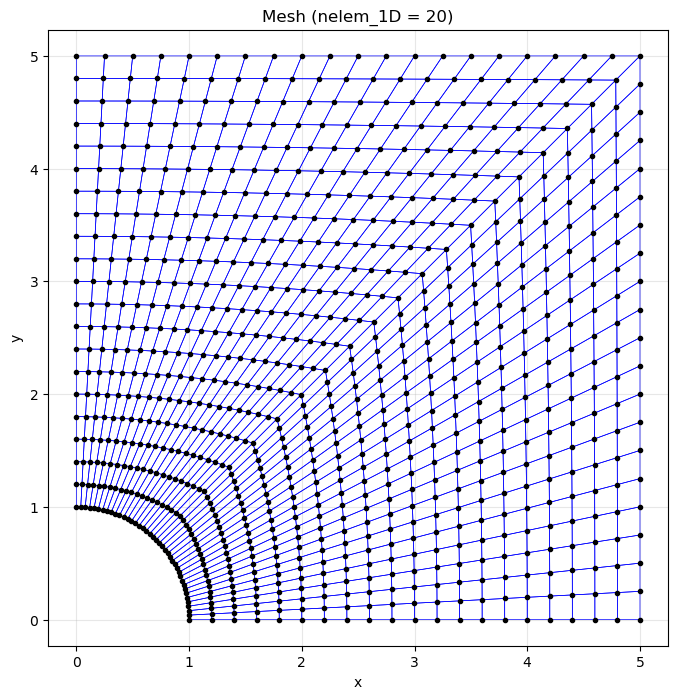


----- Solving mesh: nelem_1D = 25, mesh size h = 0.1600 -----

===== 开始计算能量范数误差 =====
 S = 
[[ 0.00091 -0.00039  0.     ]
 [-0.00039  0.00091  0.     ]
 [ 0.       0.       0.0026 ]]

单元 0，高斯点 (-0.58,-0.58):
  应变误差: [-6.17342987e-05 -6.06576773e-06 -2.94406621e-05]
  贡献值: 0.000000，累计能量误差平方: 0.000000

单元 100，高斯点 (-0.58,-0.58):
  应变误差: [-4.14864897e-05 -1.29015528e-05 -1.10485298e-04]
  贡献值: 0.000000，累计能量误差平方: 0.000000

单元 200，高斯点 (-0.58,-0.58):
  应变误差: [ 6.33037033e-06 -3.81176946e-05 -1.73143715e-04]
  贡献值: 0.000000，累计能量误差平方: 0.000001

单元 300，高斯点 (-0.58,-0.58):
  应变误差: [ 7.52635428e-05 -7.68982504e-05 -1.96415137e-04]
  贡献值: 0.000000，累计能量误差平方: 0.000002

单元 400，高斯点 (-0.58,-0.58):
  应变误差: [ 0.00015047 -0.0001175  -0.00016412]
  贡献值: 0.000000，累计能量误差平方: 0.000003

单元 500，高斯点 (-0.58,-0.58):
  应变误差: [ 2.09827186e-04 -1.43145521e-04 -7.72764672e-05]
  贡献值: 0.000000，累计能量误差平方: 0.000005

单元 600，高斯点 (-0.58,-0.58):
  应变误差: [ 2.22298582e-04 -1.33376658e-04  3.04724144e-05]
  贡献值: 0.000000，累计能量误差平方:

In [11]:
# Mesh refinement study
refinements = [10, 15, 20, 25]
h_vals = []
err_vals = []

print("Energy Norm Error Analysis")
print("-" * 50)

for nelem_1D in refinements:
    # Generate mesh
    coords, elements, fixnodes, dloads, nnode, nelem = mesh_platehole_matlab(nelem_1D)
    
    # Mesh size
    h = (L - R) / nelem_1D
    h_vals.append(h)
    
    # Solve FEM
    print(f"\n----- Solving mesh: nelem_1D = {nelem_1D}, mesh size h = {h:.4f} -----")
    U = solve_fem_matlab(coords, elements, fixnodes, dloads, D)
    
    # Calculate energy error norm
    error = calculate_energy_norm_error_matlab(coords, elements, U, D)
    err_vals.append(error)
    
    print(f"nelem_1D = {nelem_1D:3d}, h = {h:.4f}, Energy norm error = {error:.6f}")
    
    # Plot mesh for finest grid
    if nelem_1D == refinements[2]:
        plot_mesh(coords, elements, f"Mesh (nelem_1D = {nelem_1D})")

## 12. Plot Convergence Curve

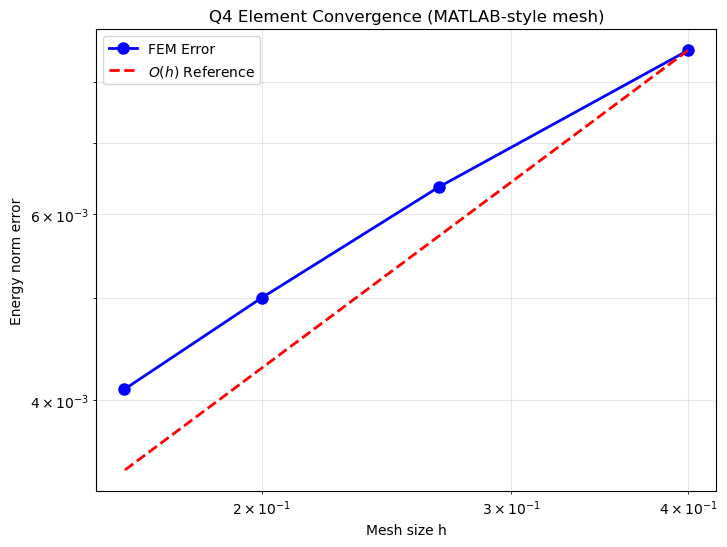

In [12]:
# Plot convergence curve
plt.figure(figsize=(8, 6))
plt.loglog(h_vals, err_vals, 'bo-', markersize=8, linewidth=2, label='FEM Error')

# Reference line
if len(h_vals) > 1:
    C = err_vals[0] / (h_vals[0]**1)
    h_ref = np.array([h_vals[0], h_vals[-1]])
    plt.loglog(h_ref, C * h_ref**1, 'r--', linewidth=2, label=r'$O(h)$ Reference')

plt.xlabel('Mesh size h')
plt.ylabel('Energy norm error')
plt.title('Q4 Element Convergence (MATLAB-style mesh)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.show()

## 13. Calculate Convergence Rate

In [13]:
# Calculate convergence rate
print("\nConvergence rate:")
print("-" * 50)
for i in range(len(h_vals)-1):
    rate = np.log(err_vals[i+1]/err_vals[i]) / np.log(h_vals[i+1]/h_vals[i])
    print(f"h: {h_vals[i]:.4f} → {h_vals[i+1]:.4f}, Convergence rate = {rate:.4f}")


Convergence rate:
--------------------------------------------------
h: 0.4000 → 0.2667, Convergence rate = 0.7360
h: 0.2667 → 0.2000, Convergence rate = 0.8395
h: 0.2000 → 0.1600, Convergence rate = 0.8938


## 14. Plot Stress Contours

Plot stress distribution for the finest mesh.


Plotting stress contours for finest mesh...


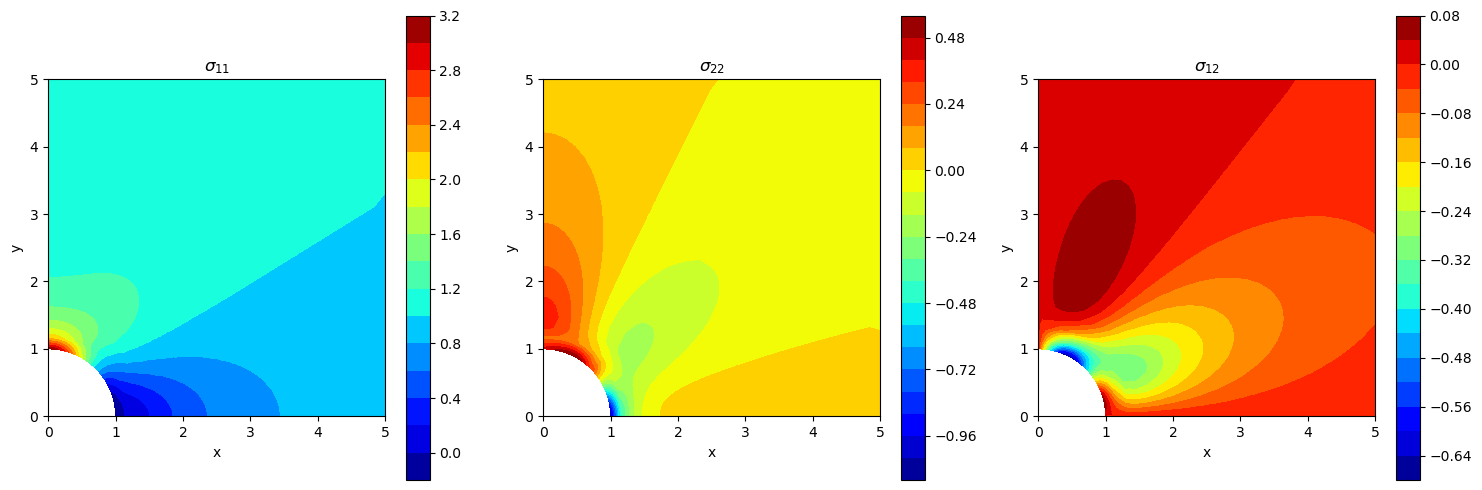


Maximum sigma_11: 3.1690


In [14]:
# Plot stress contours for finest mesh
print("\nPlotting stress contours for finest mesh...")
s11, s22, s12 = compute_stress_at_nodes(coords, elements, U, D)
plot_stress_contours(coords, elements, s11, s22, s12)

print(f"\nMaximum sigma_11: {np.max(s11):.4f}")